In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## The problem
When I did the interpolation, I checked RMSE for accelerations. The results were good. When I tried to check RMSE for the original vs. inverse profile, the latter had a tendency to diverge from the original.

In [2]:
def show_accelerations(profile_type, profile_no, interp_type = "polynomial"):
    acc = pd.read_csv("experiments/interp/{}_{}_accelerations".format(profile_type, profile_no))
    interp_acc = pd.read_csv("experiments/interp/{}_{}_{}_interp_accs".format(profile_type, profile_no, interp_type))
    print(len(acc), len(interp_acc))
    plt.plot(acc['distances'], acc['accelerations'], label = "original")
    plt.plot(interp_acc['distances'], interp_acc['accelerations'], label = "interpolated")
    plt.xlabel("Distances")
    plt.ylabel("Accelerations")
    plt.legend()

In [3]:
#show_accelerations("A", 0, "polynomial")


In [4]:
def show_profile(profile_type, profile_no, interp_type = "polynomial"):
    profile = pd.read_csv("experiments/interp/{}_{}_profile".format(profile_type, profile_no))
    interp_profile = pd.read_csv("experiments/interp/{}_{}_{}_interp_profile".format(profile_type, profile_no, interp_type))
    print(len(profile), len(interp_profile))
    plt.plot(profile['distances'], profile['elevations'], label = "original")
    plt.plot(interp_profile['distances'], interp_profile['elevations'], label = "interpolated")
    plt.xlabel("Distances")
    plt.ylabel("Elevations")
    plt.legend()

In [5]:
#show_profile("A", 0, "polynomial")

### It looks like filtering does help
I don't know however, what parameters to pass exactly. It looks like the Wb parameter helps, however it has a relationship with dx (the one that is passed to run(). This is only used to determine if the velocity that is used for simulation is constant. (If it is, the vel is just used as it is, if it's not, linearly interpolate) Therefore I test different Wb and dx parameters at the same time

In [6]:
from quartercar.qc import QC
from quartercar.roadprofile import RoadProfile
from tests import make_profile

In [7]:
def test_filtering(dx, Wn):
    prof_type = "A"

    length = 100
    seed = 0

    distances, elevations = make_profile.make_profile_from_psd(prof_type, 'sine', dx, length, seed)
    profile = RoadProfile(distances, elevations)
    iri = profile.to_iri()
    
    car = QC(208, 28, 1300, 18709, 127200)
    velocity = 30
    sample_rate_hz = 100
    T, yout, xout, new_distances, new_elevations = car.run(profile, dx, velocity, sample_rate_hz)
    accs = yout[:, -1]

    packed_vals = car.inverse(accs, new_distances, [velocity]*len(new_distances), sample_rate_hz, dx,  Wn = Wn)
    iri_after = RoadProfile(packed_vals[-2], packed_vals[0]).to_iri()
    
    return new_distances, new_elevations, packed_vals[-2], packed_vals[0], iri, iri_after

Real IRI: 2.6304486960612268, 
Estimated IRI: 2.6968679715316908


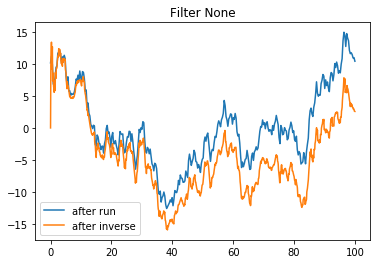

Real IRI: 2.6304486960612268, 
Estimated IRI: 2.3417428753238103


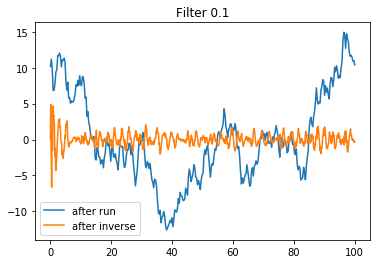

Real IRI: 2.6304486960612268, 
Estimated IRI: 2.632440694184466


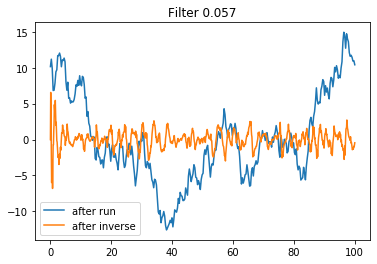

Real IRI: 2.6304486960612268, 
Estimated IRI: 2.6962718250430044


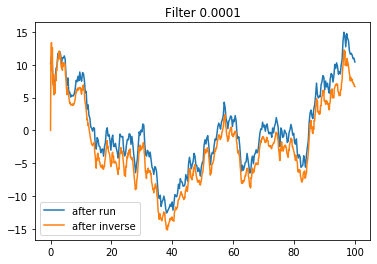

Real IRI: 2.6304486960612268, 
Estimated IRI: 2.6968679715316908


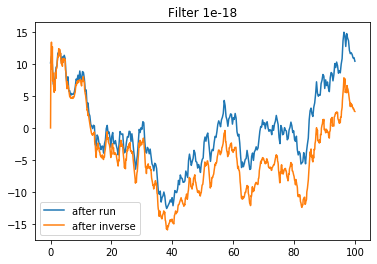

In [12]:
for Wb in [None, 0.1, 0.057, 0.0001, 0.000000000000000001]:

    dists, elevs, final_dists, final_elevs, iri1, iri2 = test_filtering(0.1, Wb)
    print("Real IRI: {}, \nEstimated IRI: {}".format(iri1, iri2))
    #plt.plot(dists, elevs, label = "original profile")
    plt.plot(dists, elevs, label = "after run")
    plt.plot(final_dists, final_elevs, label = "after inverse")
    plt.title("Filter " + str(Wb))
    plt.legend()
    plt.show()

It looks like iri estimation doesn't improve siginificantly, with a better "fit", so RMSE would not give a good indication of the model being better or worse estimating IRI.